In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math

def print_float(number):
     return "%.2f" % number

-----------

# Mission 1 - Data discovery and cleaning

The purpose of this first part is to discover the data we were handled and clean them

## Tables loading and primary key identification

In [2]:
# We get global knowledge from the table
customers = pd.read_csv('customers.csv')
customers.shape

(8623, 3)

In [3]:
# Taking a look at the table
customers.head(5)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
# We make sure the client_id is a primary key for relation customers
len(customers['client_id'].unique())

8623

In [5]:
# We get to know the second table
products = pd.read_csv('products.csv')
products.shape

(3287, 3)

In [6]:
# Taking a look at the table sample
products.head(5)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
products.loc[(products['categ'] != 0) & (products['categ'] != 1) & (products['categ'] != 2)]

,id_prod,price,categ


In [8]:
# id_prod is a primary key for the products relation
len(products['id_prod'].unique())

3287

In [9]:
# Loading the last table
transactions = pd.read_csv('transactions.csv')
transactions.shape

(337016, 4)

In [10]:
# Looking at a sample
transactions.head(5)

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [11]:
# Several calculations do not allow to determine a primary key. Duplicates are probably in the data

In [12]:
transactions_duplicated = transactions[transactions.duplicated()]
transactions_duplicated

,id_prod,date,session_id,client_id
34387,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_0
54813,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
57261,T_0,test_2021-03-01 02:30:02.237439,s_0,ct_1
58802,T_0,test_2021-03-01 02:30:02.237429,s_0,ct_0
60170,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_0
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


In [13]:
transactions_duplicated['id_prod'].unique()

array(['T_0'], dtype=object)

In [14]:
# T_0 is a legitimate id_prod
products[products['id_prod'] == 'T_0']

,id_prod,price,categ
731,T_0,-1.0,0


In [15]:
# It appears only dates including test_ as a prefix are concerned with duplicates
# Moreover those dates are not valid dates

transactions[transactions['date'] == 'test_2021-03-01 02:30:02.237421']

,id_prod,date,session_id,client_id
227121,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
293107,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1


In [16]:
# It appears that 200 data are defined as tests and therefore as non valid for our study
transactions['test'] = [ True if ('test' in date) else False for date in transactions['date']]
transactions[transactions['test']].shape

(200, 5)

Ainsi on trouve 200 entrees de test dans les transactions et il semble qu'elles soient toutes liees au produit T_0.

In [17]:
test_id_prod_mask = transactions['id_prod'] == 'T_0'
test_date_mask2 = transactions['date'].str.contains('test_.*', regex=True)
transactions.loc[test_id_prod_mask & test_date_mask2]

,id_prod,date,session_id,client_id,test
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,True
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,True
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,True
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,True
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,True
...,...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0,True
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,True
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1,True
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1,True


## Cleaning data

In [18]:
# We drop ROWs (axis=0)
customers.dropna(axis=0, how='any').shape[0]

8623

In [19]:
products.dropna(axis=0, how='any').shape[0]

3287

In [20]:
transactions.dropna(axis=0, how='any').shape[0]

337016

Ici on voit qu'il n'y a pas de valeurs manquantes dans les tables products, customers ou transactions

In [21]:
print(customers['sex'].unique())

['f' 'm']


In [22]:
products_prices_lst = products['price'].unique()
products_prices_lst.sort()
products_prices_lst

array([ -1.  ,   0.62,   0.66, ..., 247.22, 254.44, 300.  ])

Les prix n'ont pas de valeurs aberrantes en dehors de la valeur -1 associee au produit T_0 dont le nom ne semble pas correspondre a la nomenclature attendue pour les produits.

In [23]:
neg_price_mask = products['price'] < 0
products.loc[neg_price_mask]

,id_prod,price,categ
731,T_0,-1.0,0


In [24]:
prod_id_mask = products['id_prod'].str.contains('\d_\d+', regex=True)
products.loc[prod_id_mask].shape[0]

3286

Les noms des produits repondent tous a la nomenclature 'chiffre unique, underscore, un ou plusieurs chiffre', le produit T_0 etant l'unique valeur ne suivant pas cette nomenclature avec un prix negatif. Ce dernier est de plus lie aux transactions de test avec des dates non conforme. On peut donc le retirer de notre analyse.

In [25]:
id_mask = customers['client_id'].str.contains('^c(?!_\d+)', regex=True)
customers.loc[id_mask]

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


De la meme facon on identifie deux clients dont la nomenclature ne verifie pas 'c, underscore, serie de chiffre' et qui sont eux aussi associes aux donnees de transactions de test.
On verifie cela sur les donnees de transactions.

In [26]:
test_client_id_mask = transactions['client_id'].str.contains('^c(?!_\d+)', regex=True)
transactions.loc[test_client_id_mask]

,id_prod,date,session_id,client_id,test
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,True
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,True
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,True
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,True
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,True
...,...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0,True
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,True
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1,True
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1,True


Rien d'anormal sur les dates, qui sont repertoriees entre 2021 et 2022 bien que situees dans le futur au niveau des annees.

In [27]:
# All session_id match the naming convention
session_id_mask = transactions['session_id'].str.contains('s_\d+', regex=True)
transactions.loc[session_id_mask].shape[0]

337016

En resume on elimine alors les elements suivants:
- lignes de customers avec les valeurs 'ct_X'
- lignes de products avec la valeur 'T_0'
- lignes de transactions avec un des valeur precedentes ou des dates non conformes commencant par 'test_'

In [28]:
products = products.loc[prod_id_mask]
correct_id_mask = customers['client_id'].str.contains('c_\d+', regex=True)
customers = customers.loc[correct_id_mask]
test_mask = transactions['id_prod'] != 'T_0'
transactions = transactions.loc[test_mask]

In [29]:
# Checking original dataframes have been updated
print(products.shape[0], customers.shape[0], transactions.shape[0])

3286 8621 336816


In [30]:
dates = transactions.loc[:,'date'].tolist()
dates.sort()
print(dates[0], dates[-1])

2021-03-01 00:01:07.843138 2022-02-28 23:59:58.040472


-----

# Mission 2: Data analysis

Vous devrez y utiliser au moins :

- des indicateurs de tendance centrale et de dispersion
- une analyse de concentration, via une courbe de Lorenz et un indice de Gini
- des représentations graphiques, dont au moins un histogramme, une représentation avec des "boites à moustaches", et - une représentation de série temporelle (c’est à dire un graphique dont l’axe des abscisses représente des dates)
- des analyses bivariées


## Customers analysis

First we focus on the customers data

In [31]:
male_msk = customers['sex'] == 'm', 'sex'
female_msk = customers['sex'] == 'f', 'sex'
nb_males = customers.loc[male_msk].count()
nb_females = customers.loc[female_msk].count()
print(nb_males, nb_females, nb_males+nb_females)

4131 4490 8621


In [32]:
sex_freq = customers['sex'].value_counts(normalize=True)
sex_freq

f    0.520821
m    0.479179
Name: sex, dtype: float64

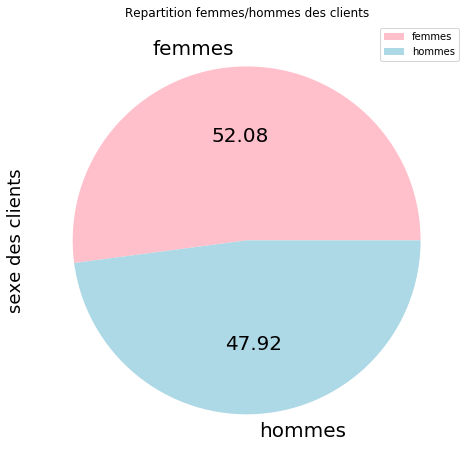

In [33]:
fig = plt.figure()
sex_freq_fig = sex_freq.plot(kind='pie',
                             labels=["femmes", "hommes"],
                             colors=["pink", "lightblue"],
                             title="Repartition femmes/hommes des clients",
                             legend=True,
                             fontsize=20,
                             autopct='%.2f',
                             figsize=(8,8),
)
plt.ylabel("sexe des clients", fontsize=18)
fig.savefig("figure_1_1_repartition_sexe.png")

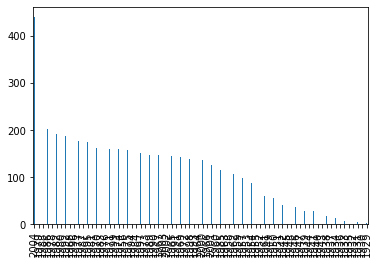

In [34]:
birth_freq = customers['birth'].value_counts()
ax = birth_freq.plot(kind='bar', width=0.1)


In [35]:
customers['age'] = 2019 - customers['birth']
customers.head()

,client_id,sex,birth,age
0,c_4410,f,1967,52
1,c_7839,f,1975,44
2,c_1699,f,1984,35
3,c_5961,f,1962,57
4,c_5320,m,1943,76


In [36]:
# Sturges rule to estimate optimal class number
kc = 1+ math.log(customers.shape[0], 2)
kc

14.07363951028323

In [37]:
women = customers.loc[customers['sex']== 'f']
men = customers.loc[customers['sex']== 'm']

women

,client_id,sex,birth,age
0,c_4410,f,1967,52
1,c_7839,f,1975,44
2,c_1699,f,1984,35
3,c_5961,f,1962,57
6,c_285,f,1967,52
...,...,...,...,...
8607,c_634,f,1979,40
8613,c_4477,f,1999,20
8619,c_7403,f,1970,49
8621,c_5643,f,1968,51


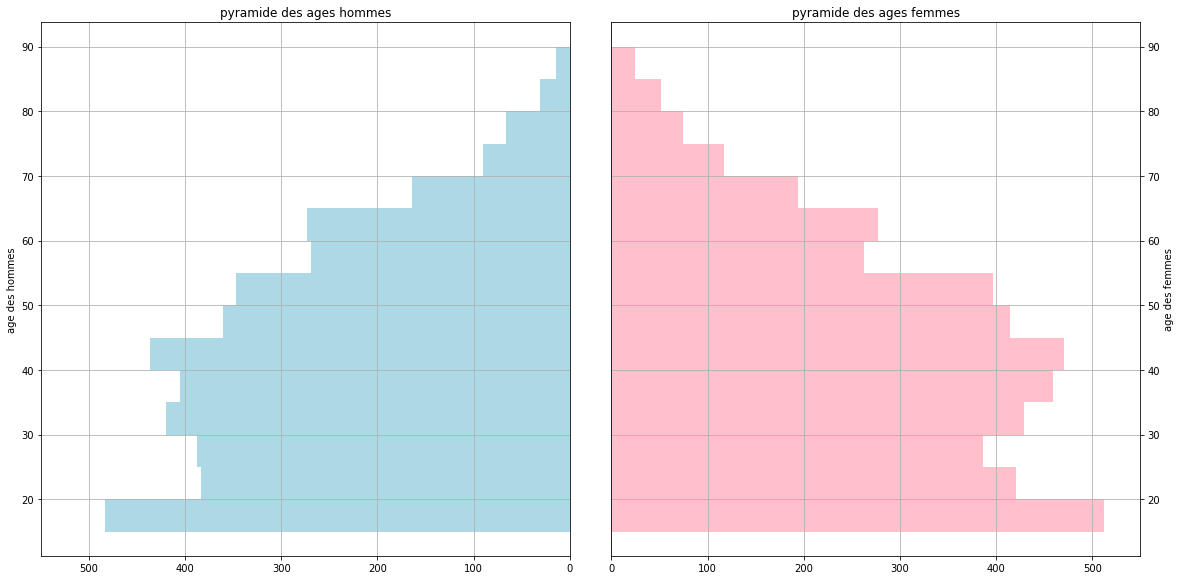

In [38]:
import matplotlib.gridspec as gridspec

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plt.tight_layout()

axw = women["age"].hist(density=False,
                  #figsize=(8,8),
                  color="pink",
                  orientation="horizontal",
                  bins=15,
                  ax=ax2)
axm = men["age"].hist(density=False,
                  #figsize=(8,8),
                  color="lightblue",
                  orientation="horizontal",
                  bins=15, 
                  ax=ax1)
ax1.set_xlim(0, 550)
ax1.invert_xaxis()
ax1.set(title="pyramide des ages hommes", ylabel='age des hommes')

ax2.set_xlim(0, 550)
ax2.set(title="pyramide des ages femmes", ylabel='age des femmes')
ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')


fig.savefig("figure_1_3_pyramides_age.png")

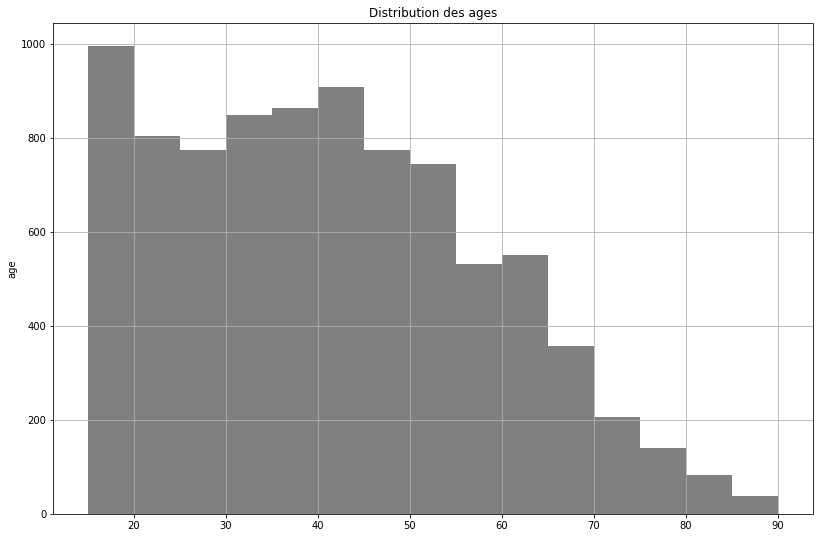

In [39]:
fig2, ax2 = plt.subplots()
plt.tight_layout()
age_freq = customers['age'].hist(density=False,
                                 figsize=(12, 8),
                                 color='grey',
                                 bins = 15,
                                 ax=ax2)
ax2.set(title="Distribution des ages", ylabel='age')

fig2.savefig("figure_1_2_repartition_age.png")

In [40]:
print(f'le pic d age est de {"%.2f" % customers["age"].mode().array[0]} ans, \n\
la valeur mediane est a {"%.2f" % customers["age"].median()} ans, \n\
et la moyenne d age est de {"%.2f" % customers["age"].mean()} annees\n\
avec un ecart type empirique de {"%.2f" % customers["age"].std(ddof=0)}\n\
skew: {"%.2f" % customers["age"].skew()}\n\
kurtosis: {"%.2f" % customers["age"].kurtosis()}\
')

le pic d age est de 15.00 ans, 
la valeur mediane est a 40.00 ans, 
et la moyenne d age est de 40.72 annees
avec un ecart type empirique de 16.92
skew: 0.36
kurtosis: -0.64


## Products analysis

In [41]:
# Sturges rule 
kp = 1 + math.log(products.shape[0],2)
kp

12.682116764950074

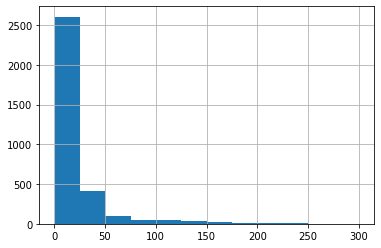

In [42]:
products['price'].hist(density=False, bins=12)

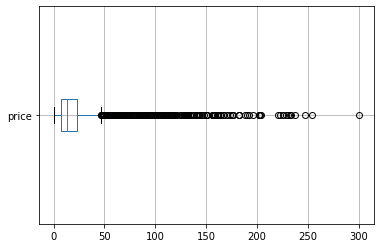

In [43]:
products.boxplot(column='price', vert=False)

In [44]:
def central_measures(series, value):
    print(f'le pic de {value} est de {print_float(series.mode().array[0])},\n\
la valeur mediane des {value} est a {print_float(series.median())},\n\
et la moyenne de {value} est de {print_float(series.mean())}\n\
avec un ecart type empirique de {print_float(series.std(ddof=0))}\n\
skew: {print_float(series.skew())}\n\
kurtosis: {print_float(series.kurtosis())}\n\
')

In [45]:
central_measures(products['price'], "prix")

le pic de prix est de 4.99,
la valeur mediane des prix est a 13.07,
et la moyenne de prix est de 21.86
avec un ecart type empirique de 29.85
skew: 3.80
kurtosis: 17.95



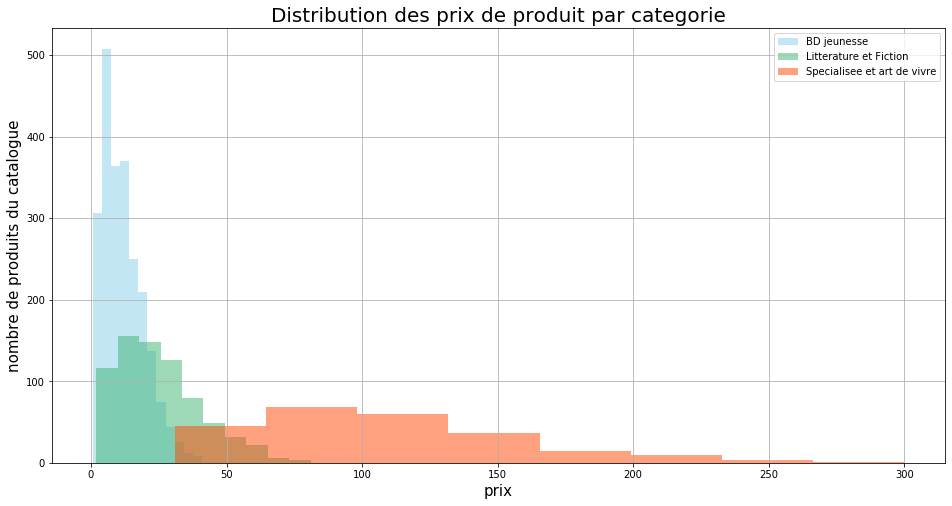

In [46]:
fig2_1, ax1 = plt.subplots(figsize=(16,8))

categ_lst = products['categ'].unique().tolist()
categ_lst.sort()
categ_map = {}

color_scheme = {
    0: "skyblue",
    1: 'mediumseagreen',
    2: 'orangered',
}

label_map = {
    0: "BD jeunesse", 
    1: "Litterature et Fiction", 
    2: "Specialisee et art de vivre",
}

for cat in categ_lst:
    msk = products['categ'] == cat, 'price'
    categ_map.update({cat: products.loc[msk]})
for cat, series in categ_map.items():
    ktab = 1 + math.log(len(series.array),2)
    ktab = math.floor(ktab)
    series.hist(density=False, 
                label=label_map[cat],
                color=color_scheme[cat],
                bins=ktab,
                alpha=0.5,
                ax=ax1)
    
ax1.set_title("Distribution des prix de produit par categorie", fontsize=20)
ax1.set_xlabel("prix", fontsize=15)
ax1.set_ylabel("nombre de produits du catalogue", fontsize=15)
ax1.get_legend()
ax1.legend()
fig2_1.savefig("figure_2_1_Distribution_prix.png")

In [47]:
for cat, series in categ_map.items():
    print(f'Pour les produits de categorie {label_map[cat]}')
    central_measures(series, "prix des produits de la categorie")
    print('\n')


Pour les produits de categorie BD jeunesse
le pic de prix des produits de la categorie est de 4.99,
la valeur mediane des prix des produits de la categorie est a 10.32,
et la moyenne de prix des produits de la categorie est de 11.73
avec un ecart type empirique de 7.56
skew: 0.84
kurtosis: 0.33



Pour les produits de categorie Litterature et Fiction
le pic de prix des produits de la categorie est de 22.99,
la valeur mediane des prix des produits de la categorie est a 22.99,
et la moyenne de prix des produits de la categorie est de 25.53
avec un ecart type empirique de 15.41
skew: 0.81
kurtosis: 0.30



Pour les produits de categorie Specialisee et art de vivre
le pic de prix des produits de la categorie est de 50.99,
la valeur mediane des prix des produits de la categorie est a 101.99,
et la moyenne de prix des produits de la categorie est de 108.35
avec un ecart type empirique de 49.46
skew: 0.93
kurtosis: 0.81





In [48]:
categ_freq = products['categ'].value_counts(normalize=True)
categ_freq

0    0.702374
1    0.224893
2    0.072733
Name: categ, dtype: float64

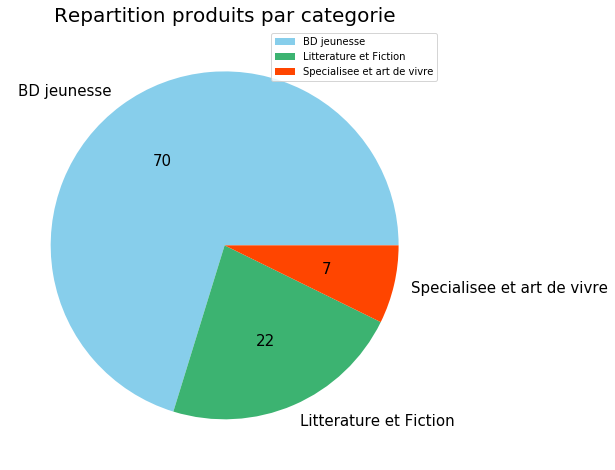

In [49]:
fig2_2, ax = plt.subplots(figsize=(8,8))

color_scheme = {
    0: "skyblue",
    1: 'mediumseagreen',
    2: 'orangered',
}

categ_freq.plot(kind='pie',
                labels=["BD jeunesse", "Litterature et Fiction", "Specialisee et art de vivre"],
                fontsize=15,
                autopct='%.0f',
                colors=["skyblue", "mediumseagreen", "orangered"],
                ax=ax
               )

ax.set_title("Repartition produits par categorie", fontsize=20)
ax.set_ylabel(None)
ax.get_legend()
ax.legend()
fig2_2.savefig("figure_2_2_Repartition produits par categorie.png")

- Merge les tables en un dataframe
- Transcrire les dates en mois heures autres
- Calculer CA par exemple

## Building main dataframe

Nous procedons au merge des donnees sur la base des cles primaires et etrangeres identifiees comme suit:
- customers avec comme cle primaire 'client_id'
- products avec comme cle primaire 'id_prod'
- transactions avec comme cles etrangeres 'client_id' et 'id_prod'

Dans une premiere etape, realiser des jointures externes permet d'identifier les cles non utilisees ou non definies. On realise ainsi les jointures par etapes:
- produits avec transactions.
- le dataframe resultant de l'operation precedente avec les clients

In [50]:
data = pd.merge(products, transactions, on='id_prod', how='outer')

In [51]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 336838 entries, 0 to 336837
Data columns (total 7 columns):
id_prod       336838 non-null object
price         336735 non-null float64
categ         336735 non-null float64
date          336816 non-null object
session_id    336816 non-null object
client_id     336816 non-null object
test          336816 non-null object
dtypes: float64(2), object(5)
memory usage: 20.6+ MB


Il y'a des produits non references dans les transactions: des produits sans prix ou categorie renseignee.

In [52]:
prod_undef = data.loc[data['price'].isnull(), ['id_prod', 'price', 'categ', 'session_id']].copy()
prod_undef

,id_prod,price,categ,session_id
336735,0_2245,NaN,NaN,s_49705
336736,0_2245,NaN,NaN,s_49323
336737,0_2245,NaN,NaN,s_124474
336738,0_2245,NaN,NaN,s_172304
336739,0_2245,NaN,NaN,s_3
...,...,...,...,...
336833,0_2245,NaN,NaN,s_16936
336834,0_2245,NaN,NaN,s_13738
336835,0_2245,NaN,NaN,s_128815
336836,0_2245,NaN,NaN,s_26624


In [53]:
unknown_prod_mask = prod_undef['id_prod'] == '0_2245'
prod_undef.loc[unknown_prod_mask]

,id_prod,price,categ,session_id
336735,0_2245,NaN,NaN,s_49705
336736,0_2245,NaN,NaN,s_49323
336737,0_2245,NaN,NaN,s_124474
336738,0_2245,NaN,NaN,s_172304
336739,0_2245,NaN,NaN,s_3
...,...,...,...,...
336833,0_2245,NaN,NaN,s_16936
336834,0_2245,NaN,NaN,s_13738
336835,0_2245,NaN,NaN,s_128815
336836,0_2245,NaN,NaN,s_26624


In [54]:
prod_undef['id_prod'].unique()

array(['0_2245'], dtype=object)

Un des produits dans les transactions n'est pas repertorie, ni en termes de prix, ni en termes de categorie.
Il sera supprime de l'etude.
Il represente 103 transactions. produit de categorie 0, sans reel impact sur l'analyse car moins de 1% des transactions.

In [55]:
data = pd.merge(data, customers, on='client_id', how='outer')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336859 entries, 0 to 336858
Data columns (total 10 columns):
id_prod       336838 non-null object
price         336735 non-null float64
categ         336735 non-null float64
date          336816 non-null object
session_id    336816 non-null object
client_id     336837 non-null object
test          336816 non-null object
sex           336837 non-null object
birth         336837 non-null float64
age           336837 non-null float64
dtypes: float64(4), object(6)
memory usage: 28.3+ MB


### Unsold products

In [57]:
session_undef = data.loc[data['session_id'].isnull(), ['id_prod', 'price', 'categ', 'session_id', 'client_id']].copy()

In [58]:
unsold_product = session_undef['id_prod'].dropna().unique().tolist()
unsold_product

['0_1016',
 '0_1780',
 '0_1062',
 '0_1119',
 '0_1014',
 '1_0',
 '0_1318',
 '0_1800',
 '0_1645',
 '0_322',
 '0_1620',
 '0_1025',
 '2_87',
 '1_394',
 '2_72',
 '0_310',
 '0_1624',
 '0_525',
 '2_86',
 '0_299',
 '0_510',
 '0_2308']

### Not purchasing customers

In [59]:
freeloader = session_undef['client_id'].dropna().unique().tolist()
freeloader

['c_8253',
 'c_3789',
 'c_4406',
 'c_2706',
 'c_3443',
 'c_4447',
 'c_3017',
 'c_4086',
 'c_6930',
 'c_4358',
 'c_8381',
 'c_1223',
 'c_6862',
 'c_5245',
 'c_5223',
 'c_6735',
 'c_862',
 'c_7584',
 'c_90',
 'c_587',
 'c_3526']

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336859 entries, 0 to 336858
Data columns (total 10 columns):
id_prod       336838 non-null object
price         336735 non-null float64
categ         336735 non-null float64
date          336816 non-null object
session_id    336816 non-null object
client_id     336837 non-null object
test          336816 non-null object
sex           336837 non-null object
birth         336837 non-null float64
age           336837 non-null float64
dtypes: float64(4), object(6)
memory usage: 28.3+ MB


### Ajouter la temporalite des donnees de transactions plus comptage et ratio des produits et clients non presents

In [61]:
book = data.dropna(axis='index', subset=['session_id'])
unknown_prod_mask = data['id_prod'] != '0_2245'
book = book.loc[unknown_prod_mask]
book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336713 entries, 0 to 336837
Data columns (total 10 columns):
id_prod       336713 non-null object
price         336713 non-null float64
categ         336713 non-null float64
date          336713 non-null object
session_id    336713 non-null object
client_id     336713 non-null object
test          336713 non-null object
sex           336713 non-null object
birth         336713 non-null float64
age           336713 non-null float64
dtypes: float64(4), object(6)
memory usage: 28.3+ MB


In [62]:
book = book.set_index(['date', 'session_id'])

In [63]:
book = book.sort_values('date')
book = book.reset_index()

Nous disposons d'un dataframe de travail trie par date et session, a partir duquel nous allons pouvoir effectuer des calculs, obtenir de nouvelles donnees. On peut ainsi evaluer:
- le CA par jour, mois, trimestre 
- repartition du chiffre d'affaire realise par client pour voir la base fidele par exemple
- evaluer la frequence d'achat par client
- faire une cartographie des categorie de produits achetes selon l'age ou le sexe des individus

## Analyses univariees

- [x] des indicateurs de tendance centrale et de dispersion
- [x] une analyse de concentration, via une courbe de Lorenz et un indice de Gini
- [x] des représentations graphiques, dont au moins un histogramme, une représentation avec des "boites à moustaches", et 
- [x] une représentation de série temporelle (c’est à dire un graphique dont l’axe des abscisses représente des dates)
- [ ] des analyses bivariées

In [64]:
book['date'] = pd.to_datetime(book['date'])
book['date_Ym'] = book['date'].dt.strftime('%Y-%m')

In [65]:
book['date_Ymd'] = book['date'].dt.strftime('%Y-%m-%d')

In [66]:
book

,date,session_id,id_prod,price,categ,client_id,test,sex,birth,age,date_Ym,date_Ymd
0,2021-03-01 00:01:07.843138,s_1,0_1259,11.99,0.0,c_329,False,f,1967.0,52.0,2021-03,2021-03-01
1,2021-03-01 00:02:26.047414,s_2,0_1390,19.37,0.0,c_664,False,m,1960.0,59.0,2021-03,2021-03-01
2,2021-03-01 00:02:38.311413,s_3,0_1352,4.50,0.0,c_580,False,m,1988.0,31.0,2021-03,2021-03-01
3,2021-03-01 00:04:54.559692,s_4,0_1458,6.55,0.0,c_7912,False,f,1989.0,30.0,2021-03,2021-03-01
4,2021-03-01 00:05:18.801198,s_5,0_1358,16.49,0.0,c_2033,False,f,1956.0,63.0,2021-03,2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
336708,2022-02-28 23:56:57.196281,s_172422,1_456,28.27,1.0,c_5787,False,f,1986.0,33.0,2022-02,2022-02-28
336709,2022-02-28 23:56:57.561424,s_172423,1_370,13.11,1.0,c_1460,False,m,1989.0,30.0,2022-02,2022-02-28
336710,2022-02-28 23:57:12.741573,s_172424,0_1538,8.61,0.0,c_1876,False,m,1983.0,36.0,2022-02,2022-02-28
336711,2022-02-28 23:59:02.381670,s_172423,0_1403,15.99,0.0,c_1460,False,m,1989.0,30.0,2022-02,2022-02-28


### Ventes - transactions

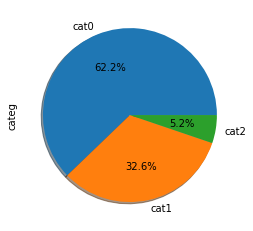

In [67]:
book['categ'].value_counts().plot(kind='pie', labels=['cat0', 'cat1', 'cat2'], autopct='%1.1f%%',shadow=True)

### Ventes- chiffre d'affaires

In [68]:
cat1_mask = book['categ'] == 1
sales_cat1_aday = book.loc[cat1_mask]
sales_cat1_aday

,date,session_id,id_prod,price,categ,client_id,test,sex,birth,age,date_Ym,date_Ymd
8,2021-03-01 00:09:11.523122,s_8,1_445,23.99,1.0,c_7991,False,m,1968.0,51.0,2021-03,2021-03-01
9,2021-03-01 00:10:20.265265,s_9,1_556,24.47,1.0,c_6171,False,m,1983.0,36.0,2021-03,2021-03-01
10,2021-03-01 00:10:33.163037,s_10,1_635,26.99,1.0,c_2218,False,f,1970.0,49.0,2021-03,2021-03-01
14,2021-03-01 00:12:38.133768,s_12,1_503,26.99,1.0,c_2505,False,f,1982.0,37.0,2021-03,2021-03-01
17,2021-03-01 00:17:11.089942,s_4,1_310,14.20,1.0,c_7912,False,f,1989.0,30.0,2021-03,2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
336693,2022-02-28 23:25:05.128894,s_172413,1_541,13.99,1.0,c_5030,False,f,1973.0,46.0,2022-02,2022-02-28
336695,2022-02-28 23:34:41.164958,s_172406,1_601,21.99,1.0,c_2996,False,m,1980.0,39.0,2022-02,2022-02-28
336697,2022-02-28 23:38:20.813781,s_172401,1_498,23.37,1.0,c_6979,False,f,1988.0,31.0,2022-02,2022-02-28
336708,2022-02-28 23:56:57.196281,s_172422,1_456,28.27,1.0,c_5787,False,f,1986.0,33.0,2022-02,2022-02-28


In [69]:
temp_mask = (sales_cat1_aday['date'] >= "2021-09-30") & (sales_cat1_aday['date'] <= "2021-11-01")
sales_cat1_aday = sales_cat1_aday.loc[temp_mask]

In [70]:
sales_cat1_aday_serie = sales_cat1_aday.groupby('date_Ymd')['date'].count()
sales_cat1_aday_serie

date_Ymd
2021-09-30    342
2021-10-01    344
2021-10-28    316
2021-10-29    326
2021-10-30    338
2021-10-31    342
Name: date, dtype: int64

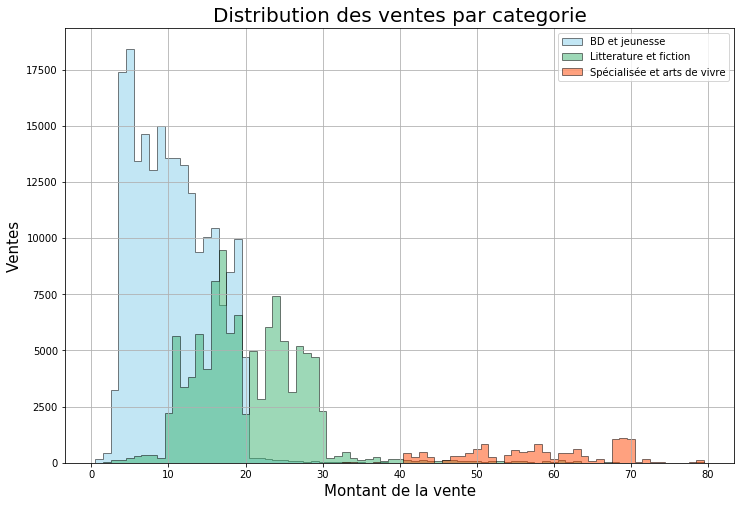

In [71]:
fig3_2, ax = plt.subplots(figsize=(12,8))

color_scheme = {
    0: "skyblue",
    1: 'mediumseagreen',
    2: 'orangered',
}
sales_acat = book[['categ', 'price']].copy()

# df masks
cat0_mask = sales_acat['categ']==0
cat1_mask = sales_acat['categ']==1
cat2_mask = sales_acat['categ']==2

# separate dataframes per cat
sales_acat0 = sales_acat[cat0_mask]
sales_acat1 = sales_acat[cat1_mask]
sales_acat2 = sales_acat[cat2_mask]

# series per cat
s0 = sales_acat0['price']
s1 = sales_acat1['price']
s2 = sales_acat2['price']

s0.hist(
    bins = [x + 0.5 for x in range(0, 80)], 
    edgecolor = 'black',
    color = "skyblue",
    label = "BD et jeunesse",
    alpha = 0.5,
    histtype = 'stepfilled',
    ax=ax
)

s1.hist(
    bins = [x + 0.5 for x in range(0, 80)], 
    edgecolor = 'black',
    color = "mediumseagreen",
    label = "Litterature et fiction",
    alpha = 0.5,
    histtype = 'stepfilled',
    ax=ax
)
s2.hist(
    bins = [x + 0.5 for x in range(0, 80)], 
    edgecolor = 'black',
    color = "orangered",
    label = "Spécialisée et arts de vivre",
    alpha = 0.5,
    histtype = 'stepfilled',
    ax=ax
)

ax.set_title("Distribution des ventes par categorie", fontsize=20)
ax.set_ylabel("Ventes", fontsize=15)
ax.set_xlabel("Montant de la vente", fontsize=15)
ax.get_legend()
ax.legend()
fig3_2.savefig("figure_3_2_Distribution des ventes.png")

In [72]:
sales_rev_monthly = book.groupby('date_Ym')['price'].sum()
sales_rev_monthly

date_Ym
2021-03    479312.03
2021-04    472980.72
2021-05    489367.95
2021-06    481257.94
2021-07    480898.66
2021-08    479305.19
2021-09    502771.28
2021-10    319159.96
2021-11    512890.17
2021-12    522937.68
2022-01    522955.31
2022-02    532740.88
Name: price, dtype: float64

In [73]:
central_measures(sales_rev_monthly, "chiffre d'affaire mensuel")

le pic de chiffre d'affaire mensuel est de 319159.96,
la valeur mediane des chiffre d'affaire mensuel est a 485312.94,
et la moyenne de chiffre d'affaire mensuel est de 483048.15
avec un ecart type empirique de 53204.87
skew: -2.62
kurtosis: 8.09



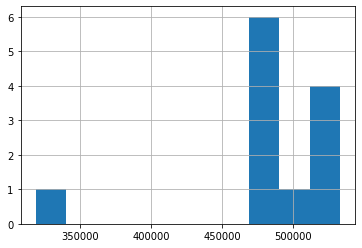

In [74]:
sales_rev_monthly.hist(density=False)

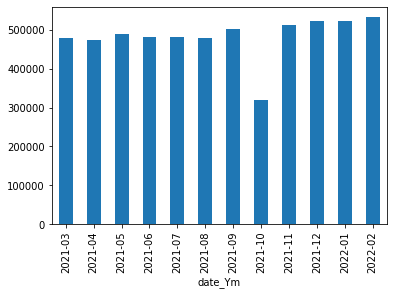

In [75]:
sales_rev_monthly.plot(kind='bar')

On observe un trou dans le CA du mois d'Octobre...

In [76]:
sales_acat_monthly = book.groupby(['categ','date_Ym'])['price'].sum()
sales_acat_monthly

categ  date_Ym
0.0    2021-03    193566.38
       2021-04    205159.67
       2021-05    196114.96
       2021-06    167886.34
       2021-07    144711.92
       2021-08    167677.82
       2021-09    246264.21
       2021-10    199217.94
       2021-11    155843.78
       2021-12    205976.44
       2022-01    164162.67
       2022-02    183140.52
1.0    2021-03    186974.17
       2021-04    156138.35
       2021-05    165893.40
       2021-06    189162.04
       2021-07    188523.27
       2021-08    162991.38
       2021-09    190613.78
       2021-10     33762.32
       2021-11    252910.39
       2021-12    251026.75
       2022-01    256267.92
       2022-02    213120.64
2.0    2021-03     98771.48
       2021-04    111682.70
       2021-05    127359.59
       2021-06    124209.56
       2021-07    147663.47
       2021-08    148635.99
       2021-09     65893.29
       2021-10     86179.70
       2021-11    104136.00
       2021-12     65934.49
       2022-01    102524.72
     

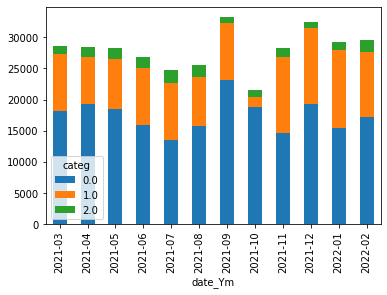

In [77]:
trans_table = pd.crosstab(index=book['date_Ym'], columns=book['categ'])
trans_table.plot(kind='bar', stacked=True)

sur le mois d'octobre les ventes de produits de cat1 ont fondu.

In [78]:
oct_cat1_mask = (book['categ']==1) & (book['date_Ym']=='2021-10')
invest_hole = book.loc[oct_cat1_mask].copy()
invest_hole

,date,session_id,id_prod,price,categ,client_id,test,sex,birth,age,date_Ym,date_Ymd
195586,2021-10-01 00:03:07.095422,s_98169,1_622,17.41,1.0,c_7614,False,m,1995.0,24.0,2021-10,2021-10-01
195587,2021-10-01 00:03:16.664480,s_98171,1_202,19.96,1.0,c_4492,False,f,1980.0,39.0,2021-10,2021-10-01
195593,2021-10-01 00:15:08.771899,s_98175,1_397,18.99,1.0,c_7176,False,f,1951.0,68.0,2021-10,2021-10-01
195598,2021-10-01 00:21:30.028255,s_98178,1_619,12.99,1.0,c_4848,False,m,1953.0,66.0,2021-10,2021-10-01
195599,2021-10-01 00:21:41.000160,s_98179,1_669,15.99,1.0,c_1773,False,f,1995.0,24.0,2021-10,2021-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...
217151,2021-10-31 23:29:35.004605,s_112945,1_588,12.62,1.0,c_7731,False,m,1968.0,51.0,2021-10,2021-10-31
217154,2021-10-31 23:39:14.623842,s_112946,1_720,10.86,1.0,c_4962,False,f,1974.0,45.0,2021-10,2021-10-31
217155,2021-10-31 23:42:21.451322,s_112941,1_493,10.99,1.0,c_8476,False,f,1959.0,60.0,2021-10,2021-10-31
217158,2021-10-31 23:48:14.590919,s_112948,1_414,23.83,1.0,c_1609,False,m,1980.0,39.0,2021-10,2021-10-31


In [79]:
invest_hole['date_d'] = invest_hole['date'].dt.strftime('%d')
invest_hole.groupby('date_d')['date_d', 'price'].sum()

,price
date_d,
01,7003.79
28,6317.99
29,6425.18
30,6753.69
31,7261.67


Manque des donnees de la categorie 1 entre le 2 et le 28 octobre 2021

In [80]:
sales_acat_sex_monthly = book.pivot_table(index='date_Ym', columns=['categ', 'sex'], values='price', aggfunc=sum)
sales_acat_sex_monthly


categ          0.0                   1.0                  2.0          
sex              f          m          f          m         f         m
date_Ym                                                                
2021-03   95711.79   97854.59   94073.70   92900.47  45084.22  53687.26
2021-04  102737.58  102422.09   78837.59   77300.76  54024.81  57657.89
2021-05   98587.00   97527.96   84083.20   81810.20  61582.09  65777.50
2021-06   82607.60   85278.74   96622.13   92539.91  56511.91  67697.65
2021-07   71562.89   73149.03   95840.22   92683.05  67970.31  79693.16
2021-08   82950.04   84727.78   82059.90   80931.48  70472.37  78163.62
2021-09  120661.88  125602.33   95025.27   95588.51  30935.62  34957.67
2021-10   96884.03  102333.91   16435.53   17326.79  41372.99  44806.71
2021-11   76139.35   79704.43  128231.41  124678.98  50974.47  53161.53
2021-12  101448.21  104528.23  126876.57  124150.18  29765.17  36169.32
2022-01   82656.35   81506.32  130542.19  125725.73  50186.82  52337.90
2022-02   91519.25   91621.27  109228.78  103891.86  58918.53  77561.19

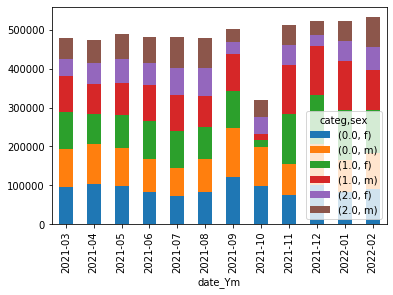

In [81]:
sales_acat_sex_monthly.plot(kind='bar', stacked=True)

In [82]:
sales_acat_monthly = book.pivot_table(index='date_Ym', columns='categ', values='price', aggfunc=sum)
sales_acat_monthly

categ,0.0,1.0,2.0
date_Ym,,,
2021-03,193566.38,186974.17,98771.48
2021-04,205159.67,156138.35,111682.70
2021-05,196114.96,165893.40,127359.59
2021-06,167886.34,189162.04,124209.56
2021-07,144711.92,188523.27,147663.47
2021-08,167677.82,162991.38,148635.99
2021-09,246264.21,190613.78,65893.29
2021-10,199217.94,33762.32,86179.70
2021-11,155843.78,252910.39,104136.00


In [83]:
warning = sales_acat_monthly[1][7] + sales_acat_monthly[0][7]
warning

232980.2599999844

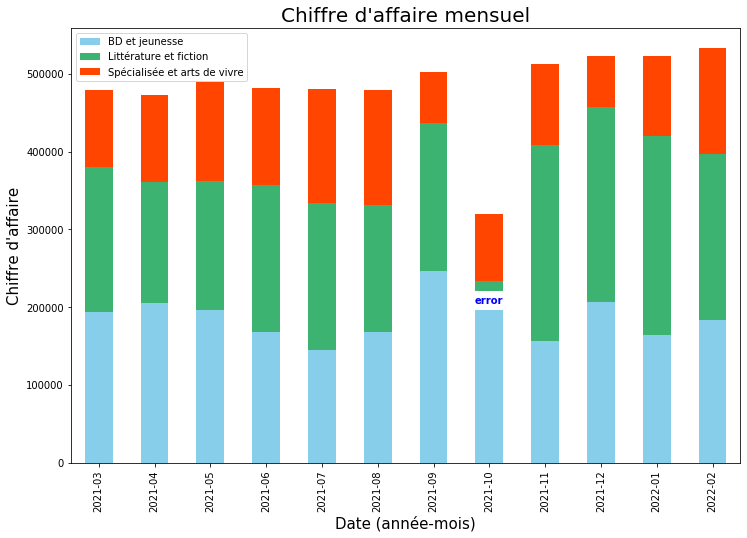

In [84]:
fig3_1, ax = plt.subplots(figsize=(12,8))

categ=["BD et jeunesse", "Littérature et fiction", "Spécialisée et arts de vivre"]
sales_acat_monthly.plot(
    label=["BD et jeunesse", "Littérature et fiction", "Spécialisée et arts de vivre"],
    color=["skyblue", "mediumseagreen", "orangered"],
    kind='bar', 
    stacked=True,
    ax=ax
)

def circle(x, y, radius=0.35):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125),
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    ax.add_artist(circle)


def text(x, y, text):
    ax.text(x, y, text, backgroundcolor="white",
            ha='center', va='top', weight='bold', color='blue')

#circle(7, 215000)
text(7, 215000, "error")
ax.set_title("Chiffre d'affaire mensuel", fontsize=20)
ax.set_ylabel("Chiffre d'affaire", fontsize=15)
ax.set_xlabel("Date (année-mois)", fontsize=15)
ax.get_legend()
ax.legend(categ)
fig3_1.savefig("figure_3_1_Repartition produits par categorie.png")

In [85]:
sales_aclient_yearly = book.groupby('client_id')['price'].sum()
sales_aclient_yearly

client_id
c_1        300.65
c_10       586.18
c_100      222.87
c_1000     980.02
c_1001    1102.45
           ...   
c_995      119.08
c_996      739.60
c_997      572.89
c_998     1527.69
c_999      305.00
Name: price, Length: 8600, dtype: float64

In [86]:
central_measures(sales_aclient_yearly, "montant achat annuel par client")

le pic de montant achat annuel par client est de 26.61,
la valeur mediane des montant achat annuel par client est a 501.31,
et la moyenne de montant achat annuel par client est de 674.02
avec un ecart type empirique de 2565.70
skew: 53.00
kurtosis: 3053.85



In [87]:
print_float(max(sales_aclient_yearly))

'162007.34'

In [88]:
greater_mask = sales_aclient_yearly > 3000
freaks = sales_aclient_yearly.loc[greater_mask].index.tolist()
freaks

['c_1609', 'c_3454', 'c_4958', 'c_6714']

In [89]:
min(sales_aclient_yearly)

4.15

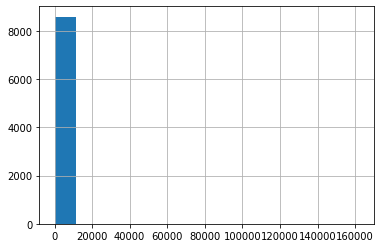

In [90]:
sales_aclient_yearly.hist(density=False, bins=14)

In [91]:
top_mask = sales_aclient_yearly==162007.34000000087
sales_aclient_yearly.loc[top_mask]

client_id
c_1609    162007.34
Name: price, dtype: float64

c_1609 est un outlier. il depense anormalement bcp

In [92]:
sales_aclient_yearly_bis = sales_aclient_yearly.drop(labels=freaks)

In [93]:
central_measures(sales_aclient_yearly_bis, "")

le pic de  est de 26.61,
la valeur mediane des  est a 501.17,
et la moyenne de  est de 623.86
avec un ecart type empirique de 457.00
skew: 1.15
kurtosis: 1.03



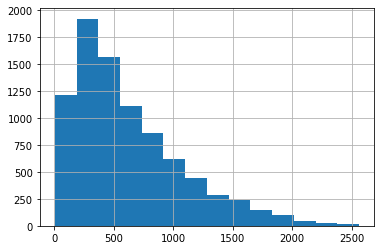

In [94]:
sales_aclient_yearly_bis.hist(density=False, bins=14)

In [95]:
sales_aclient_monthly_df = book.pivot_table(index='date_Ym', columns='client_id', values='price', aggfunc=sum)
sales_aclient_monthly_df

client_id,c_1,c_10,c_100,c_1000,c_1001,c_1002,c_1003,c_1004,c_1005,c_1006,...,c_990,c_991,c_992,c_993,c_994,c_995,c_996,c_997,c_998,c_999
date_Ym,,,,,,,,,,,,,,,,,,,,,
2021-03,NaN,14.99,NaN,160.77,357.19,NaN,133.96,63.09,7.99,211.81,...,219.95,NaN,NaN,59.99,NaN,NaN,178.19,NaN,505.96,NaN
2021-04,NaN,108.85,15.99,28.99,56.15,19.98,42.02,23.72,17.99,164.41,...,100.03,NaN,85.37,NaN,172.59,14.99,31.81,42.51,NaN,NaN
2021-05,NaN,NaN,NaN,39.63,NaN,23.99,6.51,15.99,131.05,64.68,...,145.22,NaN,NaN,62.48,43.10,23.35,101.61,20.07,375.18,NaN
2021-06,19.53,8.41,150.52,41.70,15.99,6.99,102.81,33.99,NaN,40.64,...,160.32,70.53,NaN,NaN,NaN,NaN,27.78,113.25,NaN,NaN
2021-07,55.22,55.97,NaN,39.23,NaN,NaN,14.99,28.45,NaN,257.79,...,146.70,NaN,NaN,NaN,NaN,38.75,102.04,60.37,68.47,19.50
2021-08,13.96,152.95,56.36,72.03,46.23,23.29,NaN,107.36,NaN,252.07,...,192.12,57.19,NaN,57.98,NaN,17.00,59.02,10.99,NaN,49.87
2021-09,19.98,111.74,NaN,98.89,125.13,34.53,7.45,36.70,52.08,209.28,...,43.59,82.41,21.98,NaN,NaN,NaN,NaN,147.93,13.11,49.98
2021-10,7.99,NaN,NaN,51.97,92.78,89.59,70.34,44.46,16.95,196.82,...,94.96,27.41,17.96,27.11,NaN,NaN,13.99,57.99,NaN,19.97
2021-11,136.91,45.98,NaN,100.91,120.72,57.32,81.34,27.99,70.63,128.61,...,128.43,23.99,NaN,10.29,61.05,24.99,39.95,60.67,15.99,82.29


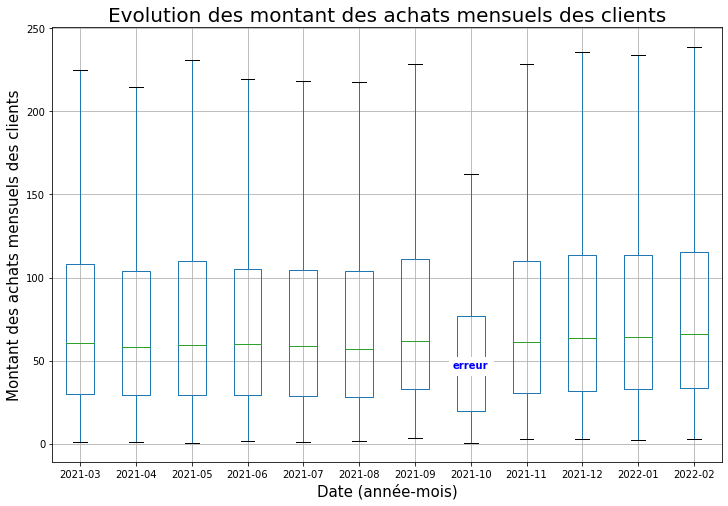

In [96]:
fig2_4, ax = plt.subplots(figsize=(12,8))
# Montly spending on average per client
sales_aclient_monthly_df.T.boxplot(showfliers=False, ax=ax)




# Montly spending on average per client
text(8, 50, "erreur")
ax.set_title("Evolution des montant des achats mensuels des clients", fontsize=20)
ax.set_ylabel("Montant des achats mensuels des clients", fontsize=15)
ax.set_xlabel("Date (année-mois)", fontsize=15)
fig2_4.savefig("figure_2_4_Montant des achats mensuels des clients.png")

In [97]:
sales_asession_monthly_df = book.pivot_table(index='date_Ym', columns='session_id', values='price', aggfunc=sum)
sales_asession_monthly_df

session_id,s_1,s_10,s_100,s_1000,s_10000,s_100000,s_100003,s_100004,s_100005,s_100007,...,s_9999,s_99990,s_99991,s_99992,s_99993,s_99994,s_99995,s_99996,s_99997,s_99998
date_Ym,,,,,,,,,,,,,,,,,,,,,
2021-03,11.99,26.99,33.72,39.22,41.49,NaN,NaN,NaN,NaN,NaN,...,34.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10,NaN,NaN,NaN,NaN,NaN,10.0,51.18,9.92,4.99,8.99,...,NaN,22.91,19.99,7.99,8.58,28.92,19.84,56.27,6.99,35.11
2021-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


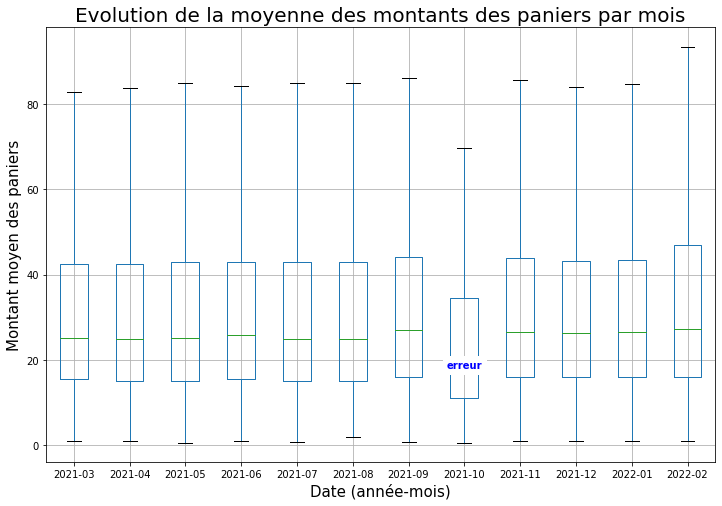

In [98]:
fig3_3, ax = plt.subplots(figsize=(12,8))

# Montly spending on average per client
sales_asession_monthly_df.T.boxplot(showfliers=False)
text(8, 20, "erreur")
ax.set_title("Evolution de la moyenne des montants des paniers par mois", fontsize=20)
ax.set_ylabel("Montant moyen des paniers", fontsize=15)
ax.set_xlabel("Date (année-mois)", fontsize=15)
fig3_3.savefig("figure_3_3_Moyenne_du_montant_des_paniers.png")

In [99]:
# Sturges rule 
kp = 1 + math.log(sales_aclient_yearly.shape[0],2)
kp

14.070120944476823

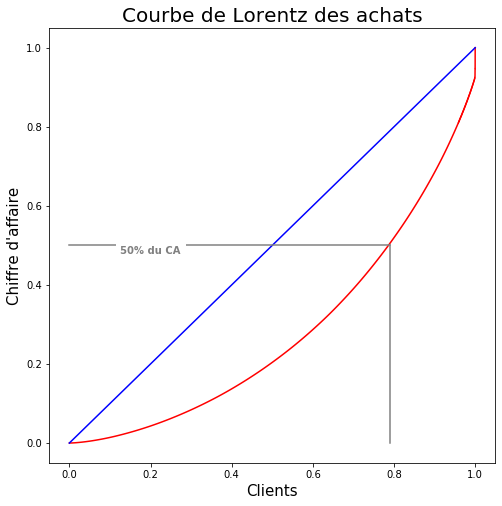

In [100]:
fig2_7, ax = plt.subplots(figsize=(8,8))


def text(x, y, text):
    ax.text(x, y, text, backgroundcolor="white",
            ha='center', va='top', weight='bold', color='grey')
#Courbe de Lorentz
lorenz = np.cumsum(np.sort(sales_aclient_yearly)) / sales_aclient_yearly.sum()
lorenz = np.append([0], lorenz)
n = len(sales_aclient_yearly)
xaxis = np.linspace(0, 1, len(lorenz))
ax.plot(xaxis, lorenz, drawstyle='steps-post', color='red')
ax.plot([0,1], [0,1], color='blue')
ax.plot([0,0.79], [0.5, 0.5], color='grey')
text(0.2, 0.5, "50% du CA")
ax.plot([0.79, 0.79], [0, 0.5], color='grey')
ax.set_title("Courbe de Lorentz des achats", fontsize=20)
ax.set_ylabel("Chiffre d'affaire", fontsize=15)
ax.set_xlabel("Clients", fontsize=15)
fig2_7.savefig("figure_2_7_Courbe de Lorentz des achats.png")

In [101]:
area_red = lorenz[:].sum()/len(lorenz)
S = 0.5 - area_red
gini = 2*S
"%.2f" % gini

'0.44'

Sur la fin gros desequilibre de 4 clients qui depensent largement plus que les autres.

In [102]:
sales_atrans_yearly = book.groupby('session_id')['price'].sum()
sales_atrans_yearly

session_id
s_1        11.99
s_10       26.99
s_100      33.72
s_1000     39.22
s_10000    41.49
           ...  
s_99994    28.92
s_99995    19.84
s_99996    56.27
s_99997     6.99
s_99998    35.11
Name: price, Length: 169173, dtype: float64

In [103]:
central_measures(sales_atrans_yearly, "montant achat par panier")

le pic de montant achat par panier est de 15.99,
la valeur mediane des montant achat par panier est a 25.56,
et la moyenne de montant achat par panier est de 34.26
avec un ecart type empirique de 31.87
skew: 3.35
kurtosis: 18.84



In [104]:
# Sturges rule 
kp = 1 + math.log(sales_atrans_yearly.shape[0],2)
kp

18.368139807230563

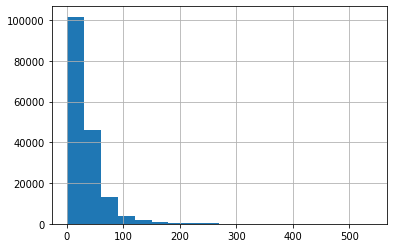

In [105]:
sales_atrans_yearly.hist(density=False, bins=18)

In [106]:
sales_asex_yearly = book.groupby('sex')['price'].sum()
sales_asex_yearly

sex
f    2.859122e+06
m    2.937456e+06
Name: price, dtype: float64

Refaire les analyses univariees sur le dataframe transactions / book
Courbe de Gini sur CA par client
Serie temporelle CA pour la serie temporelle / avec dimension categorie
Analyse bivariee: comparer 2 var qualitative, chi2 / 2 var quantit avec coef correlation lin / 1 quali et 1 quanti Kruskal Wallis ==>

### evaluer la frequence d'achat par client


In [107]:
sales_aclient_amonth = book.pivot_table(index='date_Ym', columns='client_id', values='session_id', aggfunc=len)
sales_aclient_amonth

client_id,c_1,c_10,c_100,c_1000,c_1001,c_1002,c_1003,c_1004,c_1005,c_1006,...,c_990,c_991,c_992,c_993,c_994,c_995,c_996,c_997,c_998,c_999
date_Ym,,,,,,,,,,,,,,,,,,,,,
2021-03,NaN,1.0,NaN,9.0,6.0,NaN,11.0,7.0,1.0,14.0,...,16.0,NaN,NaN,4.0,NaN,NaN,10.0,NaN,4.0,NaN
2021-04,NaN,7.0,1.0,1.0,5.0,2.0,3.0,3.0,1.0,13.0,...,8.0,NaN,5.0,NaN,6.0,1.0,2.0,1.0,NaN,NaN
2021-05,NaN,NaN,NaN,3.0,NaN,1.0,1.0,1.0,9.0,7.0,...,12.0,NaN,NaN,4.0,4.0,2.0,5.0,2.0,7.0,NaN
2021-06,1.0,1.0,2.0,3.0,1.0,1.0,10.0,1.0,NaN,4.0,...,15.0,5.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
2021-07,4.0,3.0,NaN,2.0,NaN,NaN,1.0,2.0,NaN,17.0,...,9.0,NaN,NaN,NaN,NaN,2.0,4.0,1.0,2.0,1.0
2021-08,1.0,4.0,3.0,5.0,3.0,3.0,NaN,7.0,NaN,18.0,...,16.0,4.0,NaN,2.0,NaN,2.0,3.0,1.0,NaN,3.0
2021-09,2.0,5.0,NaN,6.0,10.0,3.0,1.0,3.0,6.0,15.0,...,5.0,8.0,2.0,NaN,NaN,NaN,NaN,7.0,1.0,5.0
2021-10,1.0,NaN,NaN,3.0,6.0,7.0,8.0,4.0,1.0,15.0,...,10.0,3.0,2.0,2.0,NaN,NaN,1.0,1.0,NaN,2.0
2021-11,7.0,2.0,NaN,5.0,8.0,3.0,6.0,1.0,3.0,9.0,...,12.0,1.0,NaN,1.0,2.0,1.0,4.0,4.0,1.0,5.0


In [108]:
sales_aclient_amonth['freq'] = sales_aclient_amonth.mean(axis=1, skipna=True)

In [109]:
sales_aclient_amonth['freq'] 

date_Ym
2021-03    5.031536
2021-04    5.005464
2021-05    5.003012
2021-06    4.737940
2021-07    4.356841
2021-08    4.539171
2021-09    5.841209
2021-10    4.235768
2021-11    4.811404
2021-12    5.525311
2022-01    5.045791
2022-02    5.159016
Name: freq, dtype: float64

ici nombre de visite moyenne par client par mois. Par mois les client font en moyenne 5 achats par client

In [110]:
sales_aclient_freq_yearly = sales_aclient_amonth.mean(axis=0, skipna=True)
sales_aclient_freq_yearly

client_id
c_1       2.500000
c_10      3.500000
c_100     2.000000
c_1000    4.666667
c_1001    6.444444
            ...   
c_996     3.818182
c_997     2.555556
c_998     3.500000
c_999     2.750000
freq      4.941038
Length: 8601, dtype: float64

sur l'annee les clients font ce nombre d'achat mensuel moyen

## Analyses bivariees

- sexe et categorie qa / qa
- age et categorie qt /qa

- sexe et depenses annuelles qa / qt

- age et depenses annuelles qt / qt
- age et panier qt/qt



#### sexe et categorie

In [111]:
X = 'sex'
Y = 'categ'

cont= book[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len,margins=True, margins_name="Total")
cont

categ,0.0,1.0,2.0,Total
sex,,,,
f,103786,55469,8260,167515
m,105640,54266,9292,169198
Total,209426,109735,17552,336713


In [112]:
import seaborn as sns
from scipy.stats import chi2_contingency

tx = cont.loc[:,['Total']]
ty = cont.loc[['Total'],:]
ty

categ,0.0,1.0,2.0,Total
sex,,,,
Total,209426,109735,17552,336713


In [113]:
chi_2, p_value, dof, exp = chi2_contingency(cont)
(chi_2, p_value, dof, exp)

(81.86933350990711,
 1.467788236006804e-15,
 6,
 array([[104189.61070704,  54593.25456695,   8732.13472601,
         167515.        ],
        [105236.38929296,  55141.74543305,   8819.86527399,
         169198.        ],
        [209426.        , 109735.        ,  17552.        ,
         336713.        ]]))

In [114]:
n = len(book)
indep = tx.dot(ty)/n # Tableau d'independance
indep

categ,0.0,1.0,2.0,Total
sex,,,,
f,104189.610707,54593.254567,8732.134726,167515.0
m,105236.389293,55141.745433,8819.865274,169198.0
Total,209426.000000,109735.000000,17552.000000,336713.0


Le tableau d'independance montre ce qui devrait etre obtenu en theorie

In [115]:
c = cont.fillna(0) # Tableau de contingence
measure= (c-indep)**2/indep # normalisation
xi_n = measure.sum().sum()# double somme, d'abord sur les colonnes ==> obtention d'une serie puis somme sur celle ci
xi_n # l'indicateur du Khi2

81.86933350990711

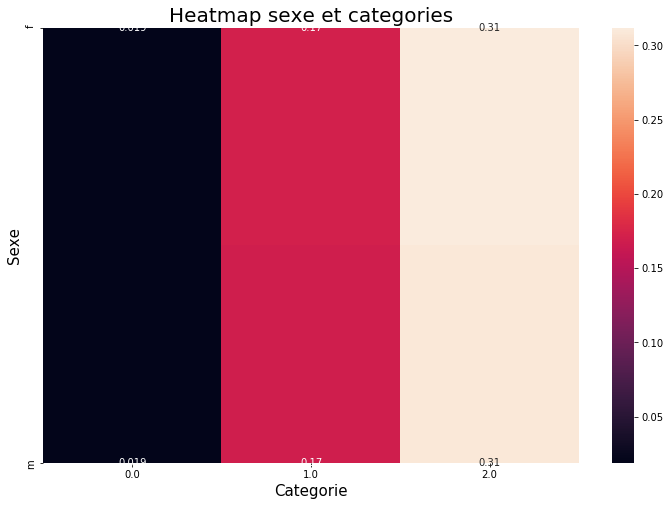

In [116]:

figC1, ax = plt.subplots(figsize=(12,8))

table = measure/xi_n
sns.heatmap(table.iloc[:-1, :-1], annot=table.iloc[:-1, :-1])


# Montly spending on average per client
#text(, 20, "erreur")
ax.set_title("Heatmap sexe et categories", fontsize=20)
ax.set_ylabel("Sexe", fontsize=15)
ax.set_xlabel("Categorie", fontsize=15)
figC1.savefig("figure_C1_Heatmap sexe et categories.png")



#### age et montant total des achats sur l'annee

In [117]:
from scipy import stats
basket = book.loc[:,['client_id', 'price']]
t_basket =basket.groupby('client_id')['price'].sum()
t_basket

client_id
c_1        300.65
c_10       586.18
c_100      222.87
c_1000     980.02
c_1001    1102.45
           ...   
c_995      119.08
c_996      739.60
c_997      572.89
c_998     1527.69
c_999      305.00
Name: price, Length: 8600, dtype: float64

In [118]:
f_basket = pd.merge(t_basket, customers, on='client_id', how='left')
outliers_mask = ~f_basket['client_id'].isin(freaks)
f_basket = f_basket.loc[outliers_mask]


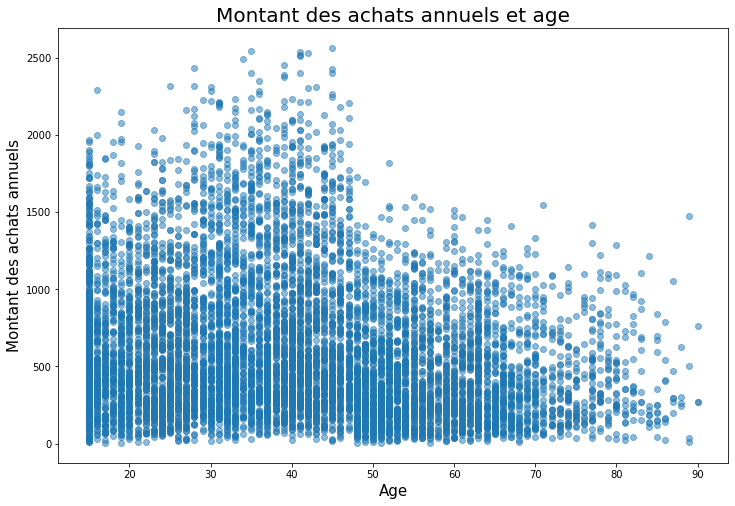

In [119]:

figC2, ax = plt.subplots(figsize=(12,8))

ax.plot(f_basket["age"], f_basket["price"],'o', alpha=0.5)


# Montly spending on average per client
#text(, 20, "erreur")
ax.set_title("Montant des achats annuels et age", fontsize=20)
ax.set_ylabel("Montant des achats annuels", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
figC2.savefig("figure_C2_Montant des achats annuels et age.png")

In [120]:
stats.pearsonr(f_basket['age'], f_basket['price'])[0]

-0.1904231605960766

In [121]:
stats.spearmanr(f_basket['age'], f_basket['price'])[0]

-0.19255508463135573

#### Age et frequence d'achat mensuelle

In [122]:
book.loc[book['client_id'] == 'c_10']

,date,session_id,id_prod,price,categ,client_id,test,sex,birth,age,date_Ym,date_Ymd
18636,2021-03-21 02:50:16.551727,s_9259,1_27,14.99,1.0,c_10,False,m,1956.0,63.0,2021-03,2021-03-21
31436,2021-04-04 01:42:10.144434,s_15668,0_1188,14.94,0.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-04
31445,2021-04-04 02:08:07.887110,s_15668,1_221,10.99,1.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-04
34900,2021-04-07 18:38:33.429322,s_17374,0_1069,7.99,0.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-07
34906,2021-04-07 18:54:37.432762,s_17374,1_249,22.99,1.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-07
34909,2021-04-07 18:56:15.648517,s_17374,0_1378,13.96,0.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-07
34932,2021-04-07 19:19:30.062238,s_17374,1_731,11.99,1.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-07
34940,2021-04-07 19:28:27.144247,s_17374,1_385,25.99,1.0,c_10,False,m,1956.0,63.0,2021-04,2021-04-07
109983,2021-06-28 17:04:25.834782,s_55109,0_1424,8.41,0.0,c_10,False,m,1956.0,63.0,2021-06,2021-06-28
123071,2021-07-14 13:09:18.582407,s_62189,0_1059,18.99,0.0,c_10,False,m,1956.0,63.0,2021-07,2021-07-14


In [123]:
freq_monthly = book.pivot_table(index='client_id', columns='date_Ym', values='session_id', aggfunc=lambda x: len(x.unique()))
freq_monthly = freq_monthly.fillna(0)
freq_monthly["purchases_amonth_mean"] = freq_monthly.mean(axis=1, skipna=False)
freq_monthly


date_Ym,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,purchases_amonth_mean
client_id,,,,,,,,,,,,,
c_1,0.0,0.0,0.0,1.0,4.0,1.0,2.0,1.0,2.0,3.0,0.0,1.0,1.250000
c_10,1.0,2.0,0.0,1.0,2.0,2.0,4.0,0.0,2.0,2.0,0.0,0.0,1.333333
c_100,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
c_1000,5.0,1.0,3.0,3.0,2.0,3.0,5.0,2.0,5.0,4.0,3.0,6.0,3.500000
c_1001,1.0,2.0,0.0,1.0,0.0,2.0,6.0,3.0,2.0,3.0,0.0,4.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_995,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.416667
c_996,7.0,1.0,4.0,2.0,4.0,3.0,0.0,1.0,4.0,6.0,2.0,2.0,3.000000
c_997,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.833333


In [124]:
f_freq = pd.merge(freq_monthly["purchases_amonth_mean"], customers, on='client_id', how='left')
outliers_mask = ~f_freq['client_id'].isin(freaks)
f_freq = f_freq.loc[outliers_mask]


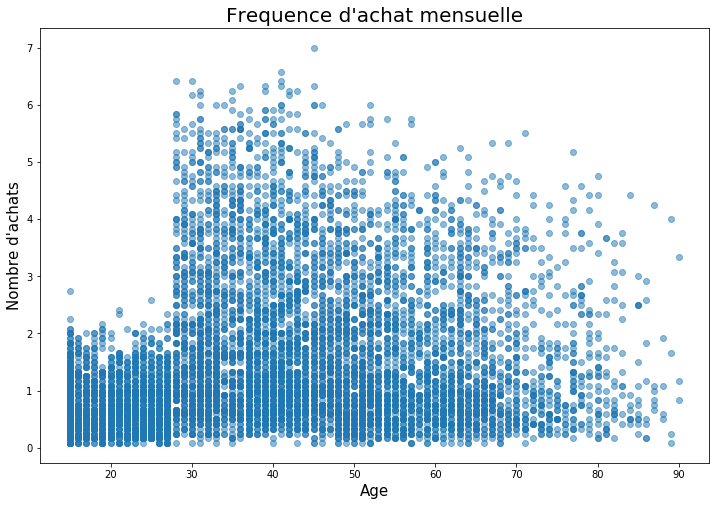

In [125]:
fig2_5, ax = plt.subplots(figsize=(12,8))

plt.plot(f_freq["age"], f_freq["purchases_amonth_mean"],'o', alpha=0.5)

# Montly spending on average per client
#text(, 20, "erreur")
ax.set_title("Frequence d'achat mensuelle", fontsize=20)
ax.set_ylabel("Nombre d'achats", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
fig2_5.savefig("figure_2_5_Frequence d'achat mensuelle.png")

In [126]:
stats.pearsonr(f_freq['age'], f_freq['purchases_amonth_mean'])[0]

0.16767714723973512

In [127]:
stats.spearmanr(f_freq['age'], f_freq['purchases_amonth_mean'])[0]

0.2174926055541009

merge sur client_id et on filtre sur derniere colonne

#### Age et taille moyenne des paniers

In [128]:
basket_size = book.loc[:,['session_id', 'id_prod']]
basket_size.loc[basket_size['session_id'] == 's_100']

,session_id,id_prod
181,s_100,0_1030
205,s_100,0_1451


In [129]:
f_basket_size = basket_size.groupby('session_id')['id_prod'].count()
f_basket_size


session_id
s_1        1
s_10       1
s_100      2
s_1000     4
s_10000    3
          ..
s_99994    3
s_99995    1
s_99996    4
s_99997    1
s_99998    3
Name: id_prod, Length: 169173, dtype: int64

In [130]:
d_basket = basket_size.pivot_table(index='session_id', values="id_prod", aggfunc=len)
d_basket.reset_index(inplace=True)
d_basket.head(20)
d_basket.columns=["session_id", "session_size"]
d_basket

,session_id,session_size
0,s_1,1
1,s_10,1
2,s_100,2
3,s_1000,4
4,s_10000,3
...,...,...
169168,s_99994,3
169169,s_99995,1
169170,s_99996,4
169171,s_99997,1


In [131]:
t_basket_size = book.loc[:,['session_id', 'id_prod', 'date_Ym']].pivot_table(index="session_id", columns="date_Ym", values="id_prod", aggfunc=len)
t_basket_size.fillna(0)

date_Ym,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
session_id,,,,,,,,,,,,
s_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_100,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_1000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_10000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
s_99994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
s_99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
s_99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


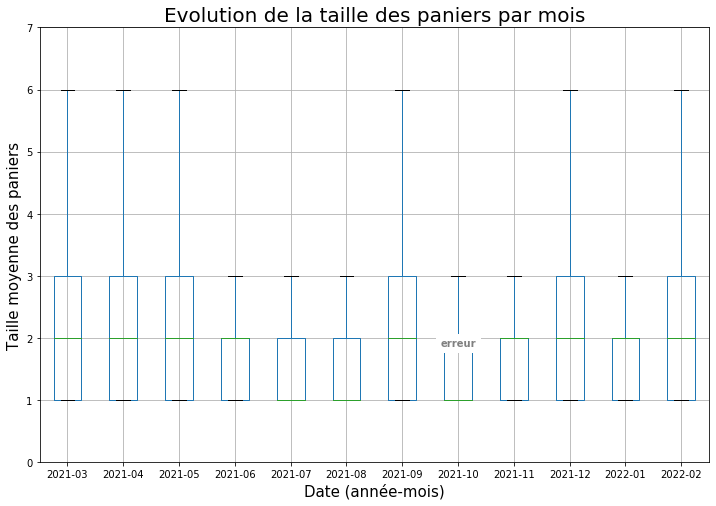

In [132]:
fig3_4, ax = plt.subplots(figsize=(12,8))


t_basket_size.boxplot(showfliers=False)

text(8, 2, "erreur")
ax.set_title("Evolution de la taille des paniers par mois", fontsize=20)
ax.set_ylabel("Taille moyenne des paniers", fontsize=15)
ax.set_ylim(0, 7)
ax.set_xlabel("Date (année-mois)", fontsize=15)
fig3_4.savefig("figure_3_4_Taille_moyenne_des_paniers.png")

In [133]:
e_basket = book.loc[:,['session_id', 'age']]
e_basket.loc[e_basket['session_id'] == 's_100']

,session_id,age
181,s_100,41.0
205,s_100,41.0


In [134]:
e_basket = e_basket.pivot_table(index='session_id', values='age')
e_basket

,age
session_id,
s_1,52.0
s_10,49.0
s_100,41.0
s_1000,30.0
s_10000,30.0
...,...
s_99994,36.0
s_99995,59.0
s_99996,45.0


In [135]:
f_basket_size = pd.merge(d_basket, book.loc[:,['session_id', 'age']], on='session_id', how='left')
f_basket_size

,session_id,session_size,age
0,s_1,1,52.0
1,s_10,1,49.0
2,s_100,2,41.0
3,s_100,2,41.0
4,s_1000,4,30.0
...,...,...,...
336708,s_99996,4,45.0
336709,s_99997,1,40.0
336710,s_99998,3,41.0
336711,s_99998,3,41.0


In [136]:
final_basket = d_basket.merge(e_basket, on='session_id', how='left')
final_basket

,session_id,session_size,age
0,s_1,1,52.0
1,s_10,1,49.0
2,s_100,2,41.0
3,s_1000,4,30.0
4,s_10000,3,30.0
...,...,...,...
169168,s_99994,3,36.0
169169,s_99995,1,59.0
169170,s_99996,4,45.0
169171,s_99997,1,40.0


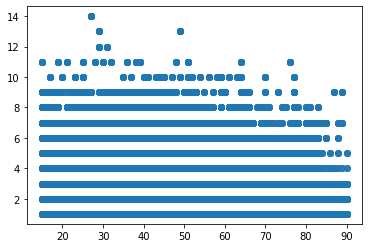

In [137]:
plt.plot(f_basket_size['age'], f_basket_size['session_size'],'o', alpha=0.5)

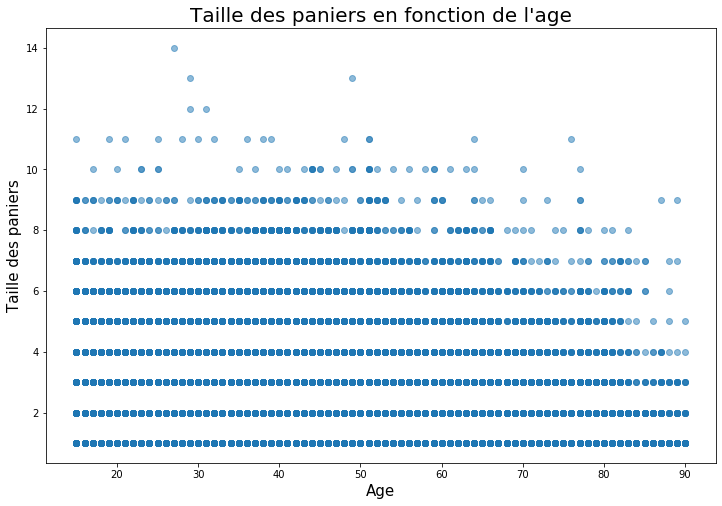

In [138]:
fig2_6, ax = plt.subplots(figsize=(12,8))
plt.plot(final_basket['age'], final_basket['session_size'],'o', alpha=0.5)


# Montly spending on average per client
#text(, 20, "erreur")
ax.set_title("Taille des paniers en fonction de l'age", fontsize=20)
ax.set_ylabel("Taille des paniers", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
fig2_6.savefig("figure_2_6_Taille des paniers en fonction de l'age.png")

In [139]:
stats.pearsonr(f_basket_size['age'], f_basket_size['session_size'])[0]

-0.14106710849061044

In [140]:
stats.spearmanr(f_basket_size['age'], f_basket_size['session_size'])[0]

-0.16959587422393899

on merge sur session id et on filtre sur cette colonne et age


#### Age et catégories de produits achetés

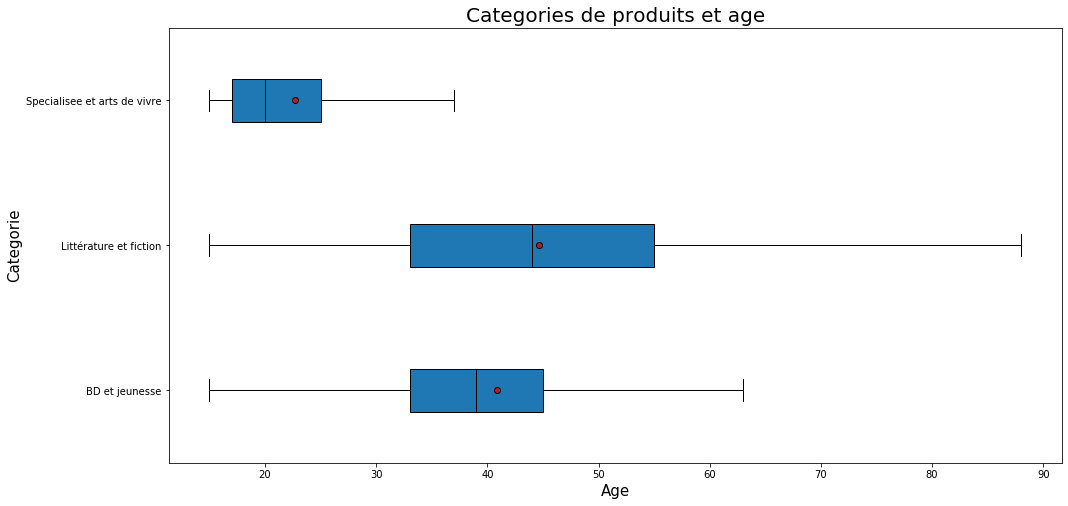

In [141]:
X = "categ" # qualitative
Y = "age" # quantitative

labels = ["BD et jeunesse", "Littérature et fiction", "Specialisee et arts de vivre"]
modalites = book[X].unique()
groupes = []
for m in modalites:
    groupes.append(book[book[X]==m][Y])

# Propriétés graphiques    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

figC4, ax = plt.subplots(figsize=(16,8))

ax.boxplot(groupes, labels=labels, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

ax.set_title("Categories de produits et age", fontsize=20)
ax.set_ylabel("Categorie", fontsize=15)
ax.set_xlabel("Age", fontsize=15)

figC4.savefig("figure_C4_Categories de produits et age.png")


In [142]:
stats.pearsonr(book["categ"], book["age"])[0]

-0.09861243223972888

In [143]:
stats.spearmanr(book["categ"], book["age"])[0]

-0.03550711311417651

In [144]:
X = "categ" # qualitative
Y = "age" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(book[X],book[Y])

0.1188683230368365